# Librerias 📚

In [2]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import models, layers
import time

2023-05-19 18:16:49.719924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Utils ⚙️

In [33]:
# Set all seed.
def set_all_seed(seed=0):
  """Set the same seed for all the libraries that we use."""
  np.random.seed(seed)

# Elegir cualquier semilla y siempre que se pueda utilizarla
# random_state = SEED
SEED = 1

set_all_seed(seed=SEED)

# Le asignamos un valor a la semilla para poder seguir un patrón de aleatoreidad.
# Esto es útil, ya que al tener una semilla, se pueden replicar los experimentos y obtener los mismos resultados.

# Code 💻

In [10]:
# Functions to determine the output size of rows and columns according to input size and dx & dy.
cols = 15
rows = 15
dx = 0.3
dy = 0.3

print('cols: ', ceil(2 * ( 2 * (0.050 * cols)/2 ) / dx) , 'rows: ', ceil(2 * ( (2 * 0.050 + (0.050 * (1.732050808 + 1)) * (rows - 1))/2 ) / dy))

cols:  5 rows:  7


In [11]:
# Data loading
with open('gruid-translator/out/out_bcal_2023-05-19T18:06:54_1-0.json') as f:
    data = json.load(f)

In [12]:
def reconstruct_matrix(data):
    # Declaration of a three-dimensional numpy matrix with two channels (side 1 and side 2) to give to a CNN.
    # The matrix will be filled with the energy deposited in each sparse coordinate (same coordinates as in the matrix).
    # The first channel is filled with the energy from the hits of the side 1 and the second channel is filled with the energy from hits of the side 2.
    
    for event, event_data in data.items():
        gruid_hits_side_1 = event_data['gruid hits - side 1']
        gruid_hits_side_2 = event_data['gruid hits - side 2']
        gruid_metadata = event_data['gruid metadata']
     
    matrix = np.zeros((gruid_metadata['# of rows (y)'], gruid_metadata['# of columns (x)'], 2))

    # IMPORTANT: Coordinates are inverted in the matrix because of matrix notation in GRUID.
    
    # Side 1
    for timestamp, timestamp_data in gruid_hits_side_1.items():
        for pixel, pixel_data in timestamp_data.items():
            x, y = pixel.split(",")
            matrix[ int(y), int(x), 0 ] = pixel_data['energy deposited']

    # Side 2
    for timestamp, timestamp_data in gruid_hits_side_2.items():
        for pixel, pixel_data in timestamp_data.items():
            x, y = pixel.split(",")
            matrix[ int(y), int(x), 1 ] = pixel_data['energy deposited']
        
    return matrix

(7, 5, 2)
[[[0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]]

 [[0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]]

 [[0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [1.85042e-06 1.51277e-04]
  [0.00000e+00 5.82220e-05]
  [0.00000e+00 0.00000e+00]]

 [[5.71700e-05 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [7.63248e-04 7.01048e-05]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]]

 [[0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [5.59196e-05 3.84594e-05]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]]

 [[0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [8.76451e-05 2.46668e-05]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]]

 [[0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00]
  [3.89985e-05 6.16744e-05]
  [0.00000e+00 0.00000e+00]
  [0.00000e+00 0.00000e+00

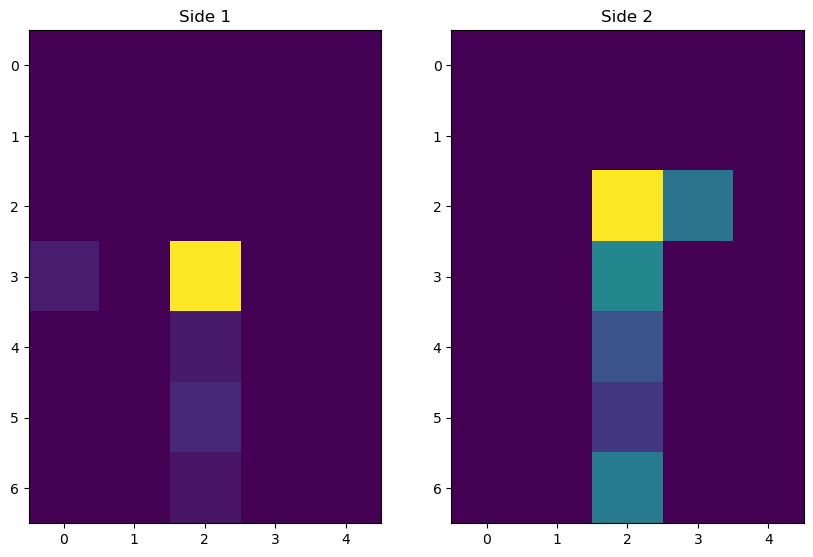

In [13]:
# Print matrix shape
np.set_printoptions(precision=5, suppress=False)

# Reconstruction of the matrix
matrix = reconstruct_matrix(data)

# Plotting the matrix
print(matrix.shape)
print(matrix)

# Plotting the matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(matrix[:, :, 0])
axs[0].set_title("Side 1")
axs[1].imshow(matrix[:, :, 1])
axs[1].set_title("Side 2")
plt.show()

In [88]:
# CNN
# We will use a CNN to classify the events.
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters and the second convolutional layer will have 64 filters.
# The first dense layer will have 64 neurons and the second dense layer will have 2 neurons (one for each class).
# The activation function of the first dense layer will be ReLU and the activation function of the second dense layer will be softmax.
# The loss function will be categorical crossentropy and the optimizer will be Adam.
# The metrics will be accuracy, AUC and F1-score.

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(gruid_metadata['# of rows (y)'], gruid_metadata['# of columns (x)'], 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall(),
                         keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(), keras.metrics.TruePositives(),
                         keras.metrics.TrueNegatives(), keras.metrics.PrecisionAtRecall(0.5), keras.metrics.RecallAtPrecision(0.5),
                         keras.metrics.AUC(curve='PR'), keras.metrics.AUC(curve='ROC'), keras.metrics.PrecisionAtRecall(0.5),
                         keras.metrics.RecallAtPrecision(0.5), keras.metrics.AUC(curve='PR'), keras.metrics.AUC(curve='ROC')]
                )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 282, 208, 32)      608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 141, 104, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 139, 102, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 69, 51, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 225216)            0         
                                                                 
 dense (Dense)               (None, 64)                1

2023-05-12 05:50:15.005970: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Notes 📝

In [14]:
# Generamos un dataframe con los metadatos de los eventos.
df_metadata = pd.DataFrame.from_dict(data, orient='index')
df_metadata = df_metadata['gruid metadata'].apply(pd.Series)
df_metadata.index.name = 'event'
df_metadata


,# of columns (x),# of rows (y),dt,dx,dy,pid
event,,,,,,
bcal_2023-05-19T18:06:54_r15c15.txt event 1,5.0,7.0,5.0,0.3,0.3,13.0


In [15]:
results = []
for event, event_data in data.items():
    gruid_hits_side_1 = event_data['gruid hits - side 1']
    gruid_hits_side_2 = event_data['gruid hits - side 2']
    gruid_metadata = event_data['gruid metadata']
    run, event_n = event.split("event")
    
    for channel, channel_data in gruid_hits_side_1.items():
        for pixel, pixel_data in channel_data.items():
            results.append({
                'run': run,
                'event': int(event_n),
                'channel': channel,
                'x': pixel[0],
                'y': pixel[2],
                'side': 1,
                'num_hits': pixel_data['# of hits'],
                'energy_deposited': pixel_data['energy deposited'],
                'particle_id': gruid_metadata['pid']
            })
            
    for channel, channel_data in gruid_hits_side_2.items():
        for pixel, pixel_data in channel_data.items():
            results.append({
                'run': run,
                'event': int(event_n),
                'channel': channel,
                'x': pixel[0],
                'y': pixel[2],
                'side': 2,
                'num_hits': pixel_data['# of hits'],
                'energy_deposited': pixel_data['energy deposited'],
                'particle_id': gruid_metadata['pid']
            })
            
df = pd.DataFrame(results)


In [16]:
df

,run,event,channel,x,y,side,num_hits,energy_deposited,particle_id
0,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,0,3,1,13,0.000057,13
1,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,2,1,1,0.000002,13
2,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,3,1,144,0.000763,13
3,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,4,1,12,0.000056,13
4,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,5,1,14,0.000088,13
5,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,6,1,6,0.000039,13
6,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,2,2,26,0.000151,13
7,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,3,2,11,0.000070,13
8,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,4,2,7,0.000038,13
9,bcal_2023-05-19T18:06:54_r15c15.txt,1,0.0,2,5,2,7,0.000025,13


In [17]:
# Check the dimensions of the dataframe
print(df.shape)
print("")
# Get summary statistics for numeric columns
print(df.describe())
print("")
# Check the data types of each column and the number of non-null values
print(df.info())
print("")

(12, 9)

       event       side    num_hits  energy_deposited  particle_id
count   12.0  12.000000   12.000000         12.000000         12.0
mean     1.0   1.500000   21.916667          0.000117         13.0
std      0.0   0.522233   38.920568          0.000207          0.0
min      1.0   1.000000    1.000000          0.000002         13.0
25%      1.0   1.000000    7.000000          0.000039         13.0
50%      1.0   1.500000   11.500000          0.000058         13.0
75%      1.0   2.000000   13.250000          0.000074         13.0
max      1.0   2.000000  144.000000          0.000763         13.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   run               12 non-null     object 
 1   event             12 non-null     int64  
 2   channel           12 non-null     object 
 3   x                 12 non-null     object 
 4 

In [21]:
# create separate dataframes for each event and side
df_e1s1 = df[(df['event'] == 1) & (df['side'] == 1)]
df_e1s2 = df[(df['event'] == 1) & (df['side'] == 2)]
df_e2s1 = df[(df['event'] == 2) & (df['side'] == 1)]
df_e2s2 = df[(df['event'] == 2) & (df['side'] == 2)]

In [22]:
# create separate dataframes for each event
df_e1 = df[df['event'] == 1]
df_e2 = df[df['event'] == 2]
df_e3 = df[df['event'] == 3]
df_e4 = df[df['event'] == 4]
df_e5 = df[df['event'] == 5]

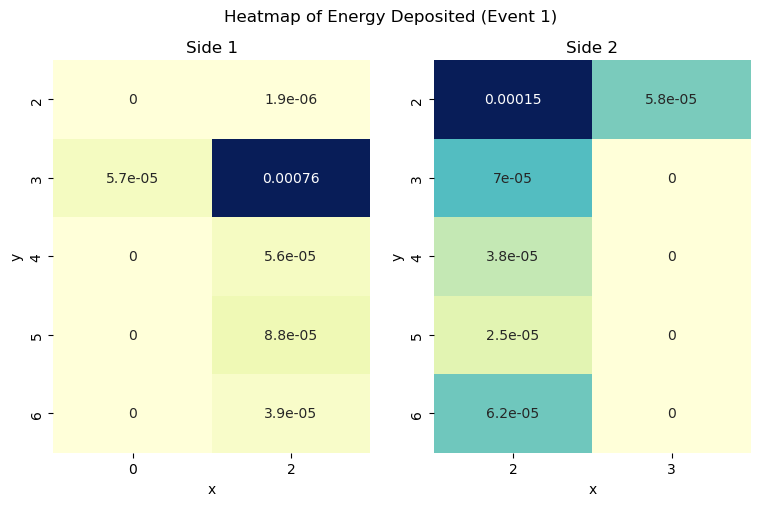

In [23]:
heatmap_e1s1 = pd.pivot_table(df_e1s1, values="energy_deposited", index="y", columns="x", fill_value=0)
heatmap_e1s2 = pd.pivot_table(df_e1s2, values="energy_deposited", index="y", columns="x", fill_value=0)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('Heatmap of Energy Deposited (Event 1)')

sns.heatmap(heatmap_e1s1, ax=axs[0], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[0].set_title("Side 1")
tile.set_position([.5, 1.05])

sns.heatmap(heatmap_e1s2, ax=axs[1], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[1].set_title("Side 2")
tile.set_position([.5, 1.05])


ValueError: zero-size array to reduction operation fmin which has no identity

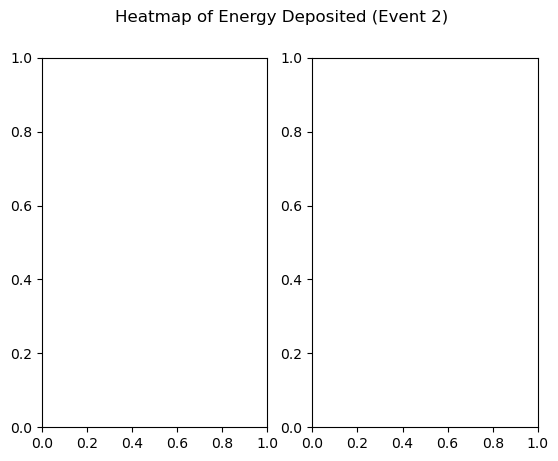

In [24]:
heatmap_e2s1 = pd.pivot_table(df_e2s1, values="energy_deposited", index="y", columns="x", fill_value=0)
heatmap_e2s2 = pd.pivot_table(df_e2s2, values="energy_deposited", index="y", columns="x", fill_value=0)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('Heatmap of Energy Deposited (Event 2)')

sns.heatmap(heatmap_e2s1, ax=axs[0], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[0].set_title("Side 1")
tile.set_position([.5, 1.05])

sns.heatmap(heatmap_e2s2, ax=axs[1], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[1].set_title("Side 2")
tile.set_position([.5, 1.05])


In [17]:
#heatmap_e1s1 = pd.pivot_table(df_e1s1, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e1s1, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 1) - Side 1')
#plt.show()

#heatmap_e1s2 = pd.pivot_table(df_e1s2, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e1s2, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 1) - Side 2')

#heatmap_e2s1 = pd.pivot_table(df_e2s1, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e2s1, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 2) - Side 1')

#heatmap_e2s2 = pd.pivot_table(df_e2s2, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e2s2, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 2) - Side 2')

In [19]:
# Print the numpy arrays in a more readable format with high precision and with scientific notation
np.set_printoptions(precision=5, suppress=False)
print(matrix_e1s1)
print("")
print(matrix_e1s2)
print("")
print(matrix_e2s1)
print("")
print(matrix_e2s2)


[[1.05585e-05 4.00372e-07]
 [1.98322e-05 1.34814e-05]
 [1.70444e-05 2.02319e-05]
 [4.97806e-06 5.15432e-06]
 [0.00000e+00 4.51526e-06]
 [0.00000e+00 5.89259e-06]]

[[4.91028e-07 2.57451e-05]
 [2.21679e-06 7.27175e-07]
 [0.00000e+00 2.60582e-05]
 [0.00000e+00 6.84840e-05]
 [0.00000e+00 7.77505e-06]]

[[2.44484e-06]
 [2.22461e-05]]

[[2.63286e-05 0.00000e+00]
 [8.58213e-06 2.69036e-06]
 [0.00000e+00 1.92749e-05]
 [0.00000e+00 2.24529e-05]
 [0.00000e+00 1.86784e-05]
 [0.00000e+00 7.88103e-06]]


<Axes: ylabel='Density'>

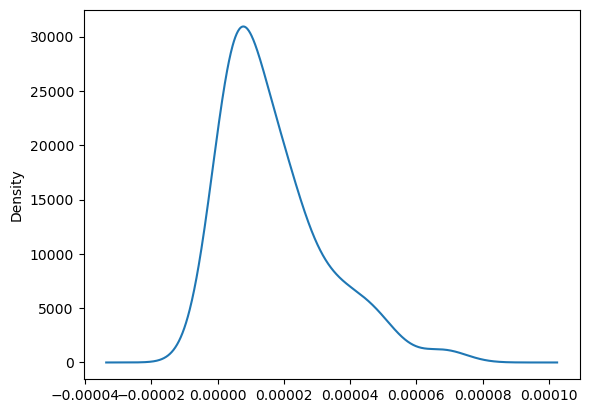

In [21]:
# Create histograms or density plots to visualize the distribution of numeric columns
#df['num_hits'].hist()
df['energy_deposited'].plot.density()

In [ ]:
#IDEA

'''
data = open("gruid-translator/out/out__1-0.json", "r").read()

# Initialize empty lists to store the data
means_side1 = []
stds_side1 = []
means_side2 = []
stds_side2 = []

# Loop through each event and calculate the mean and standard deviation of energy deposited
for event in data:
    # Side 1
    energy_side1 = []
    for k, v in data[int(event)]["gruid hits - side 1"]["0.0"].items():
        energy_side1.extend([hit["energy deposited"] for hit in v.values()])
    means_side1.append(np.mean(energy_side1))
    stds_side1.append(np.std(energy_side1))
    
    # Side 2
    energy_side2 = []
    for k, v in data[int(event)]["gruid hits - side 2"]["0.0"].items():
        energy_side2.extend([hit["energy deposited"] for hit in v.values()])
    means_side2.append(np.mean(energy_side2))
    stds_side2.append(np.std(energy_side2))

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].bar(range(len(data)), means_side1, yerr=stds_side1)
axs[0, 0].set_xticks(range(len(data)))
axs[0, 0].set_xticklabels(list(data.keys()))
axs[0, 0].set_ylabel("Mean energy deposited (Side 1)")
axs[0, 1].bar(range(len(data)), means_side2, yerr=stds_side2)
axs[0, 1].set_xticks(range(len(data)))
axs[0, 1].set_xticklabels(list(data.keys()))
axs[0, 1].set_ylabel("Mean energy deposited (Side 2)")
axs[1, 0].hist(energy_side1, bins=20)
axs[1, 0].set_xlabel("Energy deposited (Side 1)")
axs[1, 0].set_ylabel("Frequency")
axs[1, 1].hist(energy_side2, bins=20)
axs[1, 1].set_xlabel("Energy deposited (Side 2)")
axs[1, 1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# IDEA 
for event in data:
    total_hits = 0
    total_energy = 0
    for side in data[event]:
        for pos in data[event][side]:
            print(pos)
            for hits in data[event][side][pos]:
                total_hits += data[event][side][pos][hits]['# of hits']
                total_energy += data[event][side][pos][hits]['energy deposited']
    print(f"Event: {event}")
    print(f"Total number of hits: {total_hits}")
    print(f"Total energy deposited: {total_energy}\n")
'''

'\ndata = open("gruid-translator/out/out__1-0.json", "r").read()\n\n# Initialize empty lists to store the data\nmeans_side1 = []\nstds_side1 = []\nmeans_side2 = []\nstds_side2 = []\n\n# Loop through each event and calculate the mean and standard deviation of energy deposited\nfor event in data:\n    # Side 1\n    energy_side1 = []\n    for k, v in data[int(event)]["gruid hits - side 1"]["0.0"].items():\n        energy_side1.extend([hit["energy deposited"] for hit in v.values()])\n    means_side1.append(np.mean(energy_side1))\n    stds_side1.append(np.std(energy_side1))\n    \n    # Side 2\n    energy_side2 = []\n    for k, v in data[int(event)]["gruid hits - side 2"]["0.0"].items():\n        energy_side2.extend([hit["energy deposited"] for hit in v.values()])\n    means_side2.append(np.mean(energy_side2))\n    stds_side2.append(np.std(energy_side2))\n\n# Plot the results\nfig, axs = plt.subplots(2, 2, figsize=(10, 8))\naxs[0, 0].bar(range(len(data)), means_side1, yerr=stds_side1)\naxs[

In [5]:
dx_cols = (0.1 * cols)/2.
dy_rows = (0.1 + (rows - 1) * (0.05 * 1.732050808 + 0.05))/2.

print(dx_cols)
print(dy_rows)

1.05
1.4160254040000002
